In [55]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision  import datasets, transforms
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim 
from torchmetrics.classification  import MulticlassAccuracy, MulticlassF1Score, ConfusionMatrix

In [3]:
transforms =  transforms.Compose([
    transforms.ToTensor() ,
    transforms.Normalize((0.5, ), (0.5, ))
])

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:18<00:00, 547120.50it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 328213.41it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:03<00:00, 425157.62it/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 907297.65it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [7]:
len(test_dataset)

10000

In [8]:
test_dataset, val_dataset = random_split(test_dataset,[7000, 3000])

In [9]:
len(test_dataset)

7000

In [40]:
train = DataLoader(train_dataset, batch_size=64, shuffle=True)
test = DataLoader(test_dataset)
val = DataLoader(val_dataset,batch_size=500)

In [72]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 10)

        self.dropout = nn.Dropout(0.25)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = torch.flatten(x,start_dim=1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x


In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTClassifier().to(device=device)
lossf = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

In [74]:
for epoch in range(10):
    train_loss = 0
    model.train()
    for i, data in enumerate(train):
        image, label = data
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        model.train()

        preds = model(image)
        loss = lossf(preds,label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # if i % 10 == 0 and i!=0:
        #    model.eval()
        #    with torch.no_grad():
        #        val_loss=0
        #        F1 = MulticlassF1Score(num_classes=10, average='macro').to(device)
        #        Accurucy = MulticlassAccuracy(num_classes=10, average='macro').to(device)
        #        for images , labels in val:
        #             images, labels = images.to(device), labels.to(device)
        #             val_pred = model(images)
        #             loss = lossf(val_pred, labels)
        #             val_loss+=loss.item()

        #             F1.update(preds=val_pred, target=labels)
        #             Accurucy.update(preds=val_pred, target=labels)
        #        print(f"val_loss: {val_loss/6} | train_loss (batch : {i}):{train_loss/i} | val_accurucy: {Accurucy.compute()} | val_F1: {F1.compute()}")
    model.eval()
    with torch.no_grad():
        val_loss=0
        F1 = MulticlassF1Score(num_classes=10, average='macro').to(device)
        Accurucy = MulticlassAccuracy(num_classes=10, average='macro').to(device)
        for images , labels in val:
            images, labels = images.to(device), labels.to(device)
            val_pred = model(images)
            loss = lossf(val_pred, labels)
            val_loss+=loss.item()
            F1.update(preds=val_pred, target=labels)
            Accurucy.update(preds=val_pred, target=labels)
        print(f"val_loss: {val_loss/6} | train_loss (epoch_final):{train_loss/len(train)} | val_accurucy: {Accurucy.compute()} | val_F1: {F1.compute()}")

val_loss: 0.04092443889627854 | train_loss (epoch_final):0.17119903470288272 | val_accurucy: 0.9851438403129578 | val_F1: 0.9849947690963745
val_loss: 0.033690345784028373 | train_loss (epoch_final):0.054415722042004434 | val_accurucy: 0.987226665019989 | val_F1: 0.9872453212738037
val_loss: 0.025633735892673332 | train_loss (epoch_final):0.04026357588151704 | val_accurucy: 0.9917634725570679 | val_F1: 0.991645097732544
val_loss: 0.02233741121987502 | train_loss (epoch_final):0.03219087193916137 | val_accurucy: 0.9925059676170349 | val_F1: 0.9922890663146973
val_loss: 0.020929685793817043 | train_loss (epoch_final):0.02642161092082193 | val_accurucy: 0.992770254611969 | val_F1: 0.9926233291625977
val_loss: 0.028657194847861927 | train_loss (epoch_final):0.02109950864396989 | val_accurucy: 0.9914273023605347 | val_F1: 0.991240382194519
val_loss: 0.02497281413525343 | train_loss (epoch_final):0.018872945598827066 | val_accurucy: 0.990795910358429 | val_F1: 0.9905503988265991
val_loss: 0.

In [75]:
with torch.no_grad():
    F1_test= MulticlassF1Score(num_classes=10, average='macro').to(device)
    Accurucy_test = MulticlassAccuracy(num_classes=10, average='macro').to(device)
    cf = ConfusionMatrix(task = 'multiclass',num_classes=10).to(device)
    model.eval()
    for images , labels in test:
        images, labels = images.to(device), labels.to(device)
        test_preds = model(images)
        F1_test.update(preds=test_preds, target=labels)
        Accurucy_test.update(preds=test_preds, target=labels)
        cf.update(test_preds,labels)
    
    print(f"test -> accurucy: {Accurucy_test.compute():.4f} | F1: {F1_test.compute():.4f}")


test -> accurucy: 0.9929 | F1: 0.9929


<Axes: >

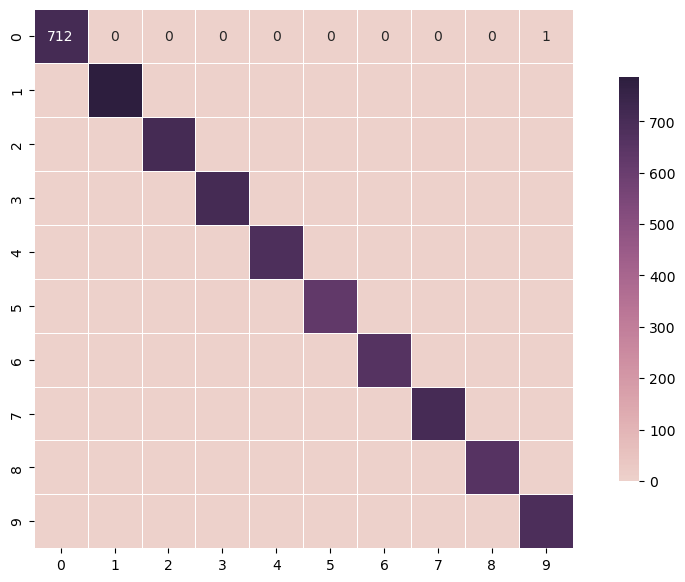

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.heatmap(cf.compute().to('cpu'),
            annot=True, 
            fmt='d', 
            cmap=sns.cubehelix_palette(as_cmap=True), 
            linewidths=0.5, 
            square=True, 
            cbar_kws={"shrink": 0.75})

## Result

| Epoch | Val Loss  | Train Loss (Final) | Val Accuracy       | Val F1 Score        |
|-------|-----------|--------------------|--------------------|---------------------|
| 1     | 0.0409    | 0.1712             | 0.9851             | 0.9850              |
| 2     | 0.0337    | 0.0544             | 0.9872             | 0.9872              |
| 3     | 0.0256    | 0.0403             | 0.9918             | 0.9916              |
| 4     | 0.0223    | 0.0322             | 0.9925             | 0.9923              |
| 5     | 0.0209    | 0.0264             | 0.9928             | 0.9926              |
| 6     | 0.0287    | 0.0211             | 0.9914             | 0.9912              |
| 7     | 0.0250    | 0.0189             | 0.9908             | 0.9906              |
| 8     | 0.0157    | 0.0170             | 0.9954             | 0.9953              |
| 9     | 0.0213    | 0.0143             | 0.9934             | 0.9933              |
| 10    | 0.0240    | 0.0135             | 0.9936             | 0.9935              |


## Final result
  - Test Accuracy: 0.9929
  - Test F1 : 0.9929